# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

In the end, this exercise is the simple start on moving into the territory of Machine Learning analysis.


### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

* Author: Troels C. Petersen (NBI) and Rasmus Ørsøe (NBI)
* Email:  petersen@nbi.dk
* Date:   17th of April 2023

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv


Possible other packages to consider: cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.


In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong


# Main program start:

Read in the data, and make arrays of each variable (and understand these!).


In [4]:
# Get data (with this very useful NumPy reader):
data = np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True)    # For faster running
# data = np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True)   # For more data

# Kinematics (energy and direction) of the jet:
energy = data['energy']
cTheta = data['cTheta']
phi    = data['phi']

# Classification variables (those used in Aleph's NN):
prob_b = data['prob_b']
spheri = data['spheri']
pt2rel = data['pt2rel']
multip = data['multip']
bqvjet = data['bqvjet']
ptlrel = data['ptlrel']

# Aleph's NN score:
nnbjet = data['nnbjet']

# Truth variable whether it really was a b-jet or not (i.e. target)
isb    = data['isb']

# Inspect the data:
Define the histogram range and binning (important - programs are generally NOT good at this):

In [5]:
Nbins = 100
xmin = 0.0
xmax = 1.0

### Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

In [6]:
prob_b_bjets = prob_b[isb == 1]
prob_b_ljets = prob_b[isb == 0]
bqvjet_bjets = bqvjet[isb == 1]
bqvjet_ljets = bqvjet[isb == 0]

### Produce 1D figures:

/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_23639/2347249079.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


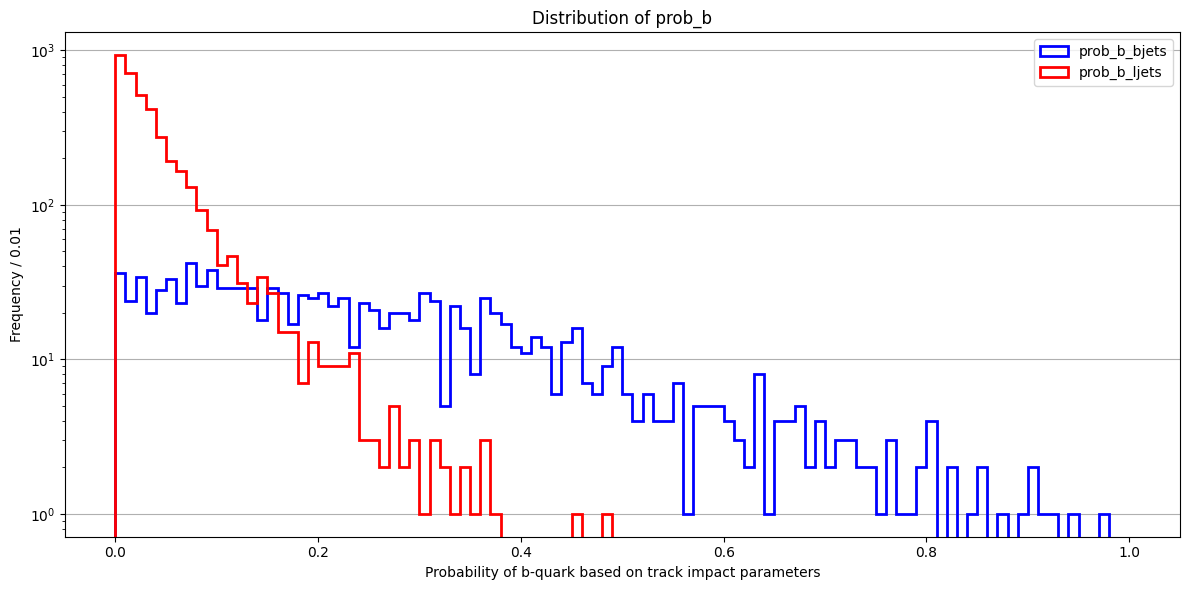

In [7]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()
fig.show()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

### Produce 2D figures:

/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_23639/2045483418.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_23639/2045483418.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


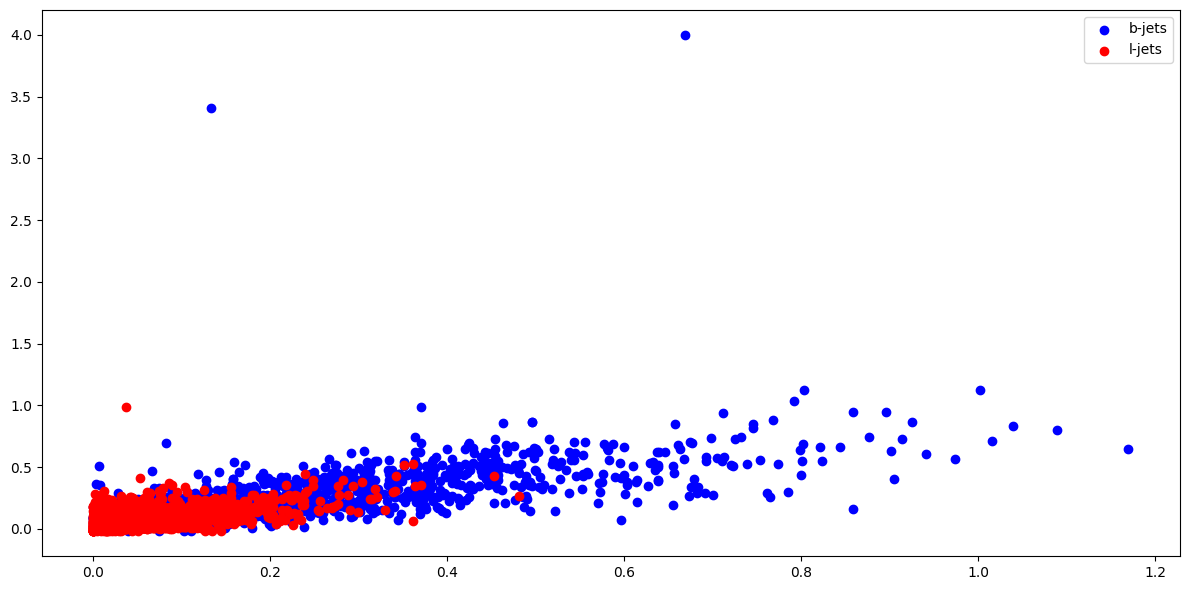

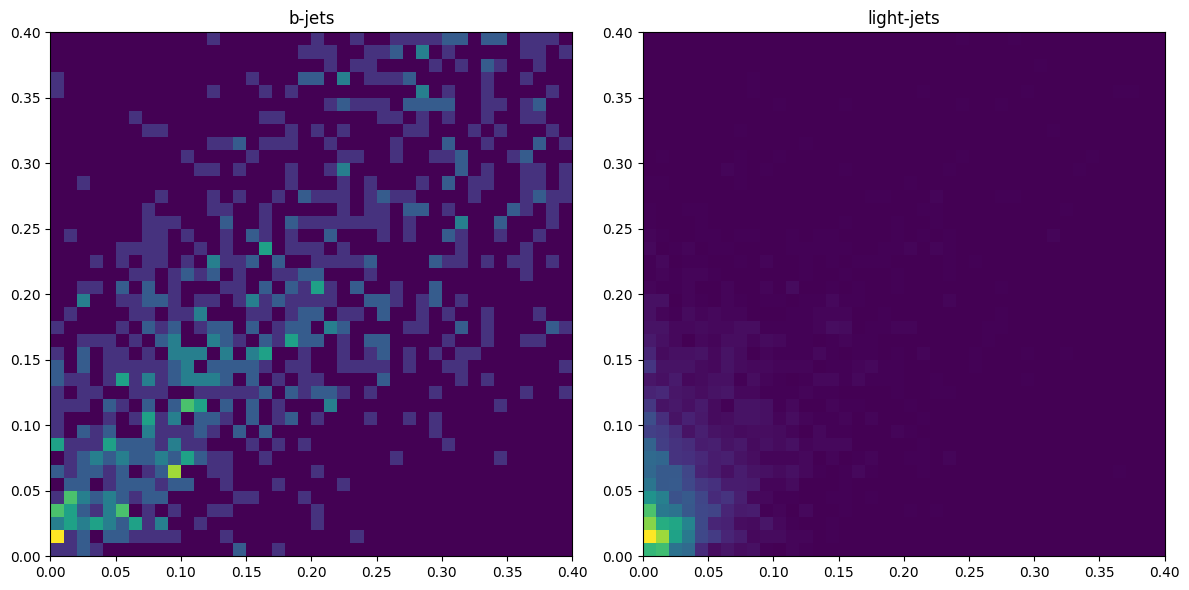

In [8]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 6))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.legend(loc='best')
fig2.tight_layout()
fig2.show()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[1].set_title("light-jets")

fig3.tight_layout()
fig3.show()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

# Selection:

In [9]:
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
# Note: This is where you change things (selection values and adding variables) to improve the performance:
cut_bqvjet = 0.20

# Think about how the above cuts "works", and then imagine what I have in mind below, trying to refine the selection:
# cut_propb = 0.15
# loose_propb = 0.07
# tight_propb = 0.26
# loose_bqvjet = 0.09
# tight_bqvjet = 0.34

# If prob_b indicate b-quark, call it a b-quark, otherwise not!
bquark=[]
for i in np.arange(len(prob_b)):
    if (bqvjet[i] > cut_bqvjet) :
        bquark.append(1)
    else :
        bquark.append(0)

### Evaluate the selection:

In [10]:
N, accuracy, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


RESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3683
  False-Negative (0,1) =  539
  False-Positive (1,0) =  139
  True-Positive (1,1)  =  639
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.1356
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.8644000000000001


### Compare with Aleph NN-approach from 1990'ies:

In [11]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


ALEPH BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3700
  False-Negative (0,1) =  372
  False-Positive (1,0) =  122
  True-Positive (1,1)  =  806
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0988
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9012


# Suggested problems:

1. Start by plotting the six "Aleph classification variables" for signal and background, and see which seems to separate most. Possibly draw ROC curves for all of these separately, to quantify this.

2. As you can see, the Aleph-NN performs significantly better. Try to optimize your cuts, combining several of them in smart ways. You may also want to make a linear combination (i.e. Fisher Linear Discriminant) to do better. Challenge yourself to push it as far as you can (well, for say 30 minutes).

3. Does including more data (50000 instead of 5000 events) help your performance?

4. Currently, the scoring (also called the loss function) is simply done by considering the fraction of wrong estimates. Think about what the alternatives could be, especially if you were to give a continuous score like the Aleph-NN.

# Learning points:

From this exercise you should get a feel for the problem at hand, namely how to separate two populations in a 6-dimensional space. It is hard to imagine, yet with simple cuts you should be able to get "some performance", though never anywhere close to the Aleph-NN. You should learn, that it is hard, but that at least the fact that you have known cases makes you capable of getting that "some performance". And you should of course be able to draw ROC curves to compare performances.

The next steps (i.e. following exercises) are to improve this performance through the use of Machine Learning (ML), and make you capable not only of getting results, but also confident in optimising them, and certainly proficient in interpreting them.

# Example Solution(s)

In [12]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import time

# Read the data

We read in the data in a slightly different way, better suited for ML-based approach 
...and we choose input and target variables:

A few worlds on the variables and feature choices:
* 'isb' is our binary truth variables. If isb = 1 then it's a b-quark and isb = 0 if it is not.
   Because this is our truth, we must not include it as the input to our model.
* 'nnbjet' is our "competitor" e.g. a model we are supposed to benchmark against.
   Therefore 'nnbjet' shouldn't be in our input either.
* 'energy', 'cTheta', and 'phi' are kinematic variables of the jet, and not about the jet type.
   Though they might help, they were not in the original Aleph NN (nnbjet), and to compare, we omit them.

Usually one would apply further checks/regularization/standardization of data at this step, but this data has already been "prepared", so we'll move onto seperate the data into input, truth and benchmark:

In [13]:
#We import the data slightly more convenient here
import pandas as pd 
from pandas import Series, DataFrame 

# Read the data in using Pandas Dataframe and print the variables:
data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True))
#data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True))

variables = data.columns
print(variables)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: ", input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')
  Variables used for training:  Index(['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'], dtype='object')


***

# Classify B-jets using LightGBM:

This is a solution example using LightGBM (tree based).

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping

start=time.time()

# Split data set into training and test set and feed these to LightGBM:
# We choose a 75:25 division here. Dataset is shuffeled before the split. 
# By using a number (42), it creates a random seed so you can rerun and obtain the same result.
input_train, input_test, truth_train, truth_test, benchmark_train, benchmark_test = train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)
lgb_train = lgb.Dataset(input_train, truth_train)
lgb_eval  = lgb.Dataset(input_test,  truth_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'binary',   # The outcome is binary, b-quark or not
    'num_leaves': 6,         # Set a maximum tree leaves to avoid overfitting
    'verbose':-1,            # Suppress some output
}

# Train the model:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                callbacks=[early_stopping(20)])     # Stops if no improvement is seen in N rounds.

# Make predictions:
y_score = gbm.predict(input_test, num_iteration=gbm.best_iteration)  # Scores are floats in the range ]0,1[.
y_pred  = [1 if pred > 0.1 else 0 for pred in y_score]               # Classify b-quark yes or no (for comparison). 

# Print the time usage:
end = time.time()
print(f"Time used by LightGBM: {(end-start)*1000:.1f} ms")

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.254291
Time used by LightGBM: 176.8 ms


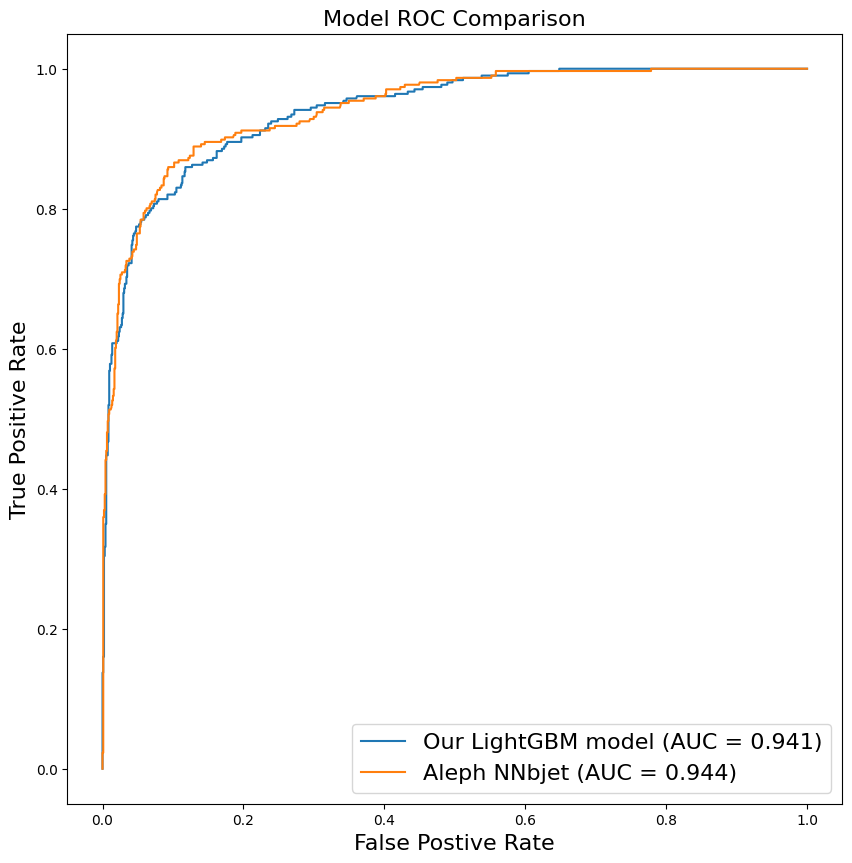

In [15]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score)                  # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our LightGBM model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.show()

***

# Classify B-jets using MLPclassifier:

This is a solution example using MLPclassifier (NN based).

In [16]:
from sklearn.neural_network import MLPClassifier

start=time.time()
clf = MLPClassifier(max_iter=20000,
                    n_iter_no_change=100,           # Number of iterations without improvement before stopping
                    solver='adam',                  # Standard for minimising
                    activation='logistic',          # Standard function (but slightly slower)
                    hidden_layer_sizes=(10, 10),    # Size of network (same as ALEPH)
                    learning_rate='invscaling',     # Other options are "constant" and "adaptive"
                    random_state=42)
clf.fit(input_test, truth_test)

# Make predictions (NOTE: This "spits out" two columns!):
y_score_MLP = clf.predict_proba(input_test)

# Print the time usage:
end = time.time()
print(f"Time used by MLPClassifier: {(end-start)*1000:.1f} ms")

Time used by MLPClassifier: 555.6 ms


Text(0, 0.5, 'True Positive Rate')

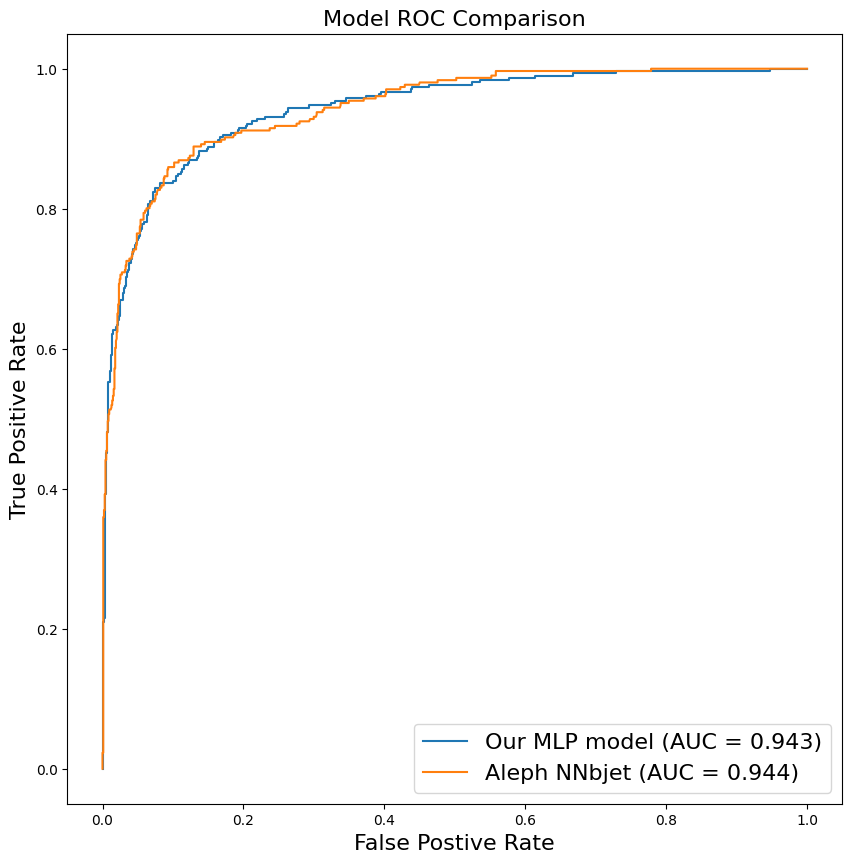

In [17]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score_MLP[:,1])              # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our MLP model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)

***

# Classify B-jets using TensorFlow:

This is a solution example using TensorFlow (NN based).

The example is built with inspiration from
https://blog.cmgresearch.com/2020/09/06/tensorflow-binary-classification.html

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Always split your dataset into train and validation part. We choose a 75:25 division here. Shuffels dataset before split. By using a number (42), it creates a random seed so you can rerun and obtain the same result.
input_train, input_valid, truth_train, truth_valid = train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

# Create a NN. Loss function is BinaryCrossEntropy. Output layer has 1 node;the prediction for isb. Learning rate defaults to 0.001. 
model = Sequential([
    Dense(6,activation='relu',name='input_layer'),
    Dense(24,activation='relu',name='hidden_layer1'),
    Dense(12,activation='relu',name='hidden_layer2'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.losses.BinaryCrossentropy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), y = np.array(truth_train), validation_data=(np.array(input_valid), np.array(truth_valid)), epochs = 7)  
## This trains the model on input_train by comparing to the true values in truth_train. After every epoch of training, the model is evaluated on the validation dataset, 
## namely input_valid and truth_valid.

Metal device set to: Apple M1 Pro
--------- TRAINING ---------
Epoch 1/7


2023-05-01 13:41:06.632594: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


118/118 [==============================] - 1s 8ms/step - loss: 0.6445 - binary_crossentropy: 0.6434 - val_loss: 0.5678 - val_binary_crossentropy: 0.5656
Epoch 2/7
118/118 [==============================] - 1s 7ms/step - loss: 0.4518 - binary_crossentropy: 0.4521 - val_loss: 0.3515 - val_binary_crossentropy: 0.3469
Epoch 3/7
118/118 [==============================] - 1s 7ms/step - loss: 0.3038 - binary_crossentropy: 0.3023 - val_loss: 0.2749 - val_binary_crossentropy: 0.2701
Epoch 4/7
118/118 [==============================] - 1s 7ms/step - loss: 0.2693 - binary_crossentropy: 0.2687 - val_loss: 0.2593 - val_binary_crossentropy: 0.2545
Epoch 5/7
118/118 [==============================] - 1s 7ms/step - loss: 0.2642 - binary_crossentropy: 0.2630 - val_loss: 0.2543 - val_binary_crossentropy: 0.2495
Epoch 6/7
118/118 [==============================] - 1s 7ms/step - loss: 0.2604 - binary_crossentropy: 0.2602 - val_loss: 0.2517 - val_binary_crossentropy: 0.2470
Epoch 7/7
118/118 [=============

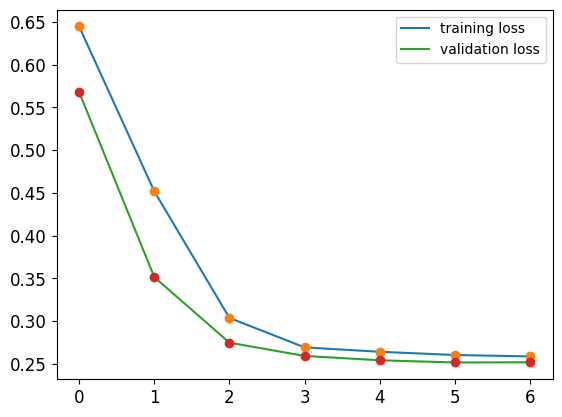

In [19]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

### Note on training curve:
As you can see, after the 3rd epoch the validation loss and training loss cross each other. This is important! Do you know why? Now we have a trained model and we're ready to make predictions. Usually, one would have a test set (so in total one would have; a training set, a validation set AND a test set). But for simplicity, let's just predict on the validation sample. **This is OK because the model has not trained on this set - if we asked the model to predict on examples on which it has trained, we would be cheating!**

In [20]:
# Now make predictions on input_valid. Notice we're not giving it any truth values!
predictions = model.predict(input_valid)

40/40 [==============================] - 0s 2ms/step


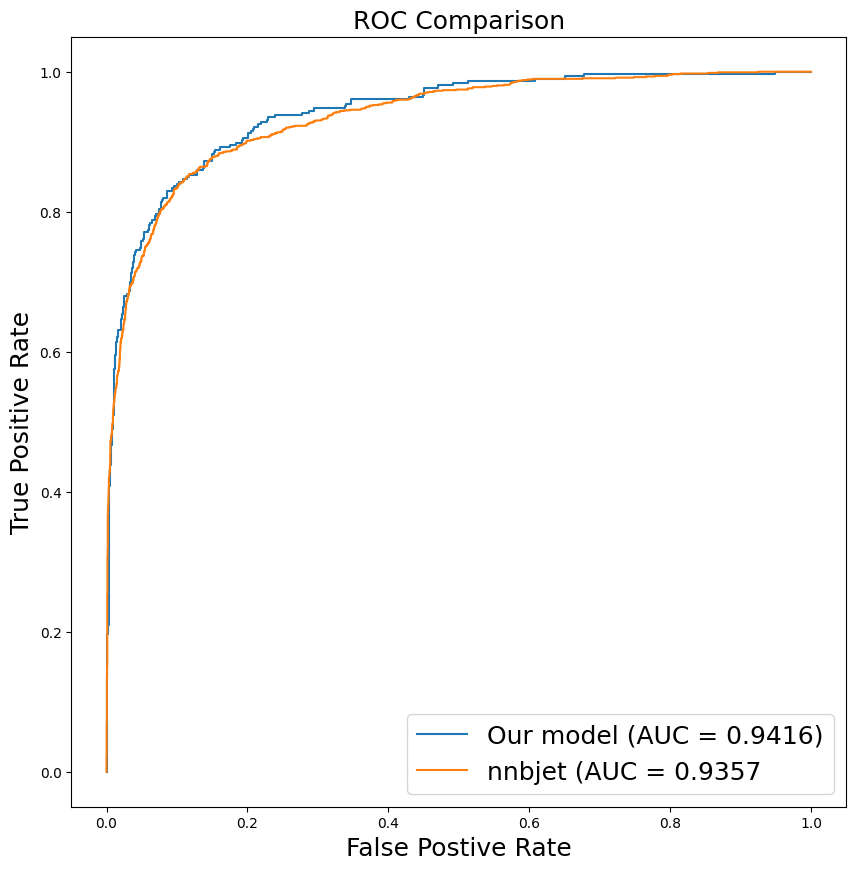

In [21]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_data, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                         # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)   # this is the auc score for nnbjet

# Plot the results:
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 18)
plt.xlabel('False Postive Rate', size = 18)
plt.ylabel('True Positive Rate', size = 18)
plt.plot(fpr,        tpr,        label = f'Our model (AUC = {auc_score:6.4f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'nnbjet (AUC = {auc_score_nnbjet:6.4f}')
plt.legend(loc='lower right', fontsize=18)
plt.show()


# Classify B-jets using PyTorch:

This is a solution example using PyTorch (NN based).

The example is built with inspiration from
https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from scipy.special import expit

#### PyTorch "specials":
PyTorch requires that we put this data into the pytorch-Dataset class, such that we can extract it during training.

PyTorch generally wants things to be written into functions and classes, which makes it slightly less easy to "just use", but once you get acquainted with this, PyTorch is a powerful and versatile tool.

In [23]:
# Training data:
class MyDataset(Dataset):    
    def __init__(self, X_data, y_data):
        self.input = X_data
        self.truth = y_data
        
    def __getitem__(self, index):
        return self.input[index], self.truth[index]
        
    def __len__ (self):
        return len(self.input)

# In pytorch, there is an additional step of turning your data into tensors:
train_data = MyDataset(torch.FloatTensor(np.array(input_train)), 
                       torch.FloatTensor(np.array(truth_train)))
valid_data = MyDataset(torch.FloatTensor(np.array(input_valid)), 
                       torch.FloatTensor(np.array(truth_valid)))

# We can now access input_train via train_data.input and truth_train via train_data.truth,
# and similarly for input_valid and truth_valid:
print(train_data.input[:2])    # Always check what your data looks like!
print(train_data.truth[:2])

tensor([[ 7.4200e-02,  3.9060e-01,  4.2900e-02,  4.1280e-01,  8.9100e-02,
         -3.0000e-04],
        [ 1.3700e-02,  6.9120e-01,  6.5200e-02,  3.9620e-01,  4.2000e-03,
         -3.0000e-04]])
tensor([0., 0.])


In [24]:
# Define the model:
class OurModel(nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()        # Here we define the layers.
        self.input_layer = nn.Linear(6, 24)     # In pytorch, you define the input and output edges explicitly.
        self.hidden_layer1 = nn.Linear(24, 24)
        self.hidden_layer2 = nn.Linear(24, 12)
        self.output_layer = nn.Linear(12, 2) 
        self.relu = nn.ReLU()
        
    def forward(self, inputs):                  # Here we define how data passes through the layers.
        x = self.input_layer(inputs)            # Also here, pytorch is a bit more explicit in defining the layers and activation function separately
        x = self.relu(x)
        x = self.hidden_layer1(x)
        x = self.relu(x)
        x = self.hidden_layer2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [25]:
# Training loop:
def Train(model, optimizer, loss_function, train_loader, validation_loader, device, epochs):
    validation_loss = []
    training_loss   = []
    model.train()
    for e in range(0, epochs):
        epoch_loss = 0
        n_minibatches = 0
        for input_train_batch, truth_train_batch in train_loader:
            input_train_batch, truth_train_batch = input_train_batch.to(device), truth_train_batch.to(device)
            optimizer.zero_grad()
            prediction = model(input_train_batch)  # This asks our model to produce predictions on the training batch            
            loss = loss_function(prediction, truth_train_batch.long())  # This calculates the loss
            loss.backward()                                             # This initiates the backpropagation
            optimizer.step()                                            # Updates the paramaters
            epoch_loss += loss.item()                                   # Extracts the loss value, such that mean loss can be calculated later (see 6 lines down)
            n_minibatches += 1
        
        # Now that the model have trained 1 epoch, we evaluate the model on the validation set:
        valid_loss = Validate(model, validation_loader, device, loss_function)
        validation_loss.append(valid_loss)
        training_loss.append(epoch_loss/n_minibatches)
        print('EPOCH: %s | training loss: %s  | validation loss: %s'%(e+1,round(epoch_loss/n_minibatches,3), round(valid_loss, 3)))
    return training_loss, validation_loss


def Validate(model, validation_loader, device, loss_function):
    model.eval()
    n_batches  = 0
    validation_loss = 0
    with torch.no_grad():
        for input_valid_batch, truth_valid_batch in validation_loader:
            input_valid_batch, truth_valid_batch = input_valid_batch.to(device), truth_valid_batch.to(device)
            prediction = model(input_valid_batch)
            loss = loss_function(prediction, truth_valid_batch.long())
            validation_loss += loss.item()
            n_batches += 1
    validation_loss = validation_loss/n_batches
    return validation_loss


def Predict(model, prediction_loader, device):
    model.eval()
    predictions = []
    print('PREDICTING!')
    with torch.no_grad():
        for input_pred_batch, _ in validation_loader:
            input_pred_batch = input_pred_batch.to(device)
            prediction = model(input_pred_batch)
            predictions.extend(prediction.numpy())
    print('Done Predicting!')
    return predictions

In [26]:
# Now everything is ready, and we thus define the optimisation (hyper-) parameters:
learning_rate = 1e-3      # The step size in the direction of "good" from stocastic gradient descent (important!)
batch_size    = 32        # The size of the batches used for each of the stocastic gradient descent calculations
n_epochs      = 8         # Number of epochs, i.e. times that we run through the entire dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OurModel() 
model.to(device)       # Mount the model to the selected device. Either CPU or GPU.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=valid_data, batch_size=batch_size)

training_loss, validation_loss = Train(model, optimizer, loss_function, train_loader, validation_loader, device, n_epochs)


EPOCH: 1 | training loss: 0.581  | validation loss: 0.522
EPOCH: 2 | training loss: 0.408  | validation loss: 0.295
EPOCH: 3 | training loss: 0.273  | validation loss: 0.248
EPOCH: 4 | training loss: 0.266  | validation loss: 0.246
EPOCH: 5 | training loss: 0.264  | validation loss: 0.248
EPOCH: 6 | training loss: 0.26  | validation loss: 0.245
EPOCH: 7 | training loss: 0.262  | validation loss: 0.246
EPOCH: 8 | training loss: 0.264  | validation loss: 0.245


This trains the model on input_train by comparing to the true values in truth_train.
After every epoch of training, the model is evaluated on the validation dataset, namely input_valid and truth_valid.


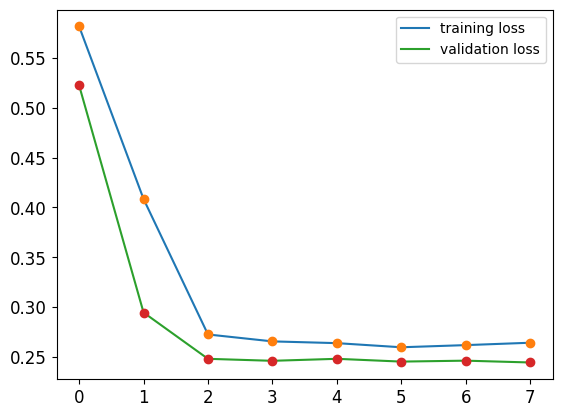

In [27]:
fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [28]:
predictions = Predict(model, validation_loader, device) # Make predictions on input_valid. Notice we're not giving it any truth values!
print("\nRaw predictions: \n", predictions[:2])

# The output of our model is raw "logits" from the final output layer.
# This means it produces a pseudo score for each class (a score for 0 and a score for 1). 
# The function "expit" converts this logit to a number in [0,1].
# We then combine the logit scores such that our_score = (1_score) / (1_score + 0_score).
predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']
predictions['not_bquark'] = expit(predictions['not_bquark'])
predictions['bquark'] = expit(predictions['bquark'])
predictions = predictions['bquark']/(predictions['bquark'] + predictions['not_bquark'])

print("\nTransformed predictions: \n", predictions[:2])

PREDICTING!
Done Predicting!

Raw predictions: 
 [array([-2.2883325,  1.3149532], dtype=float32), array([ 0.07075135, -0.8010548 ], dtype=float32)]

Transformed predictions: 
 0    0.895400
1    0.374389
dtype: float32


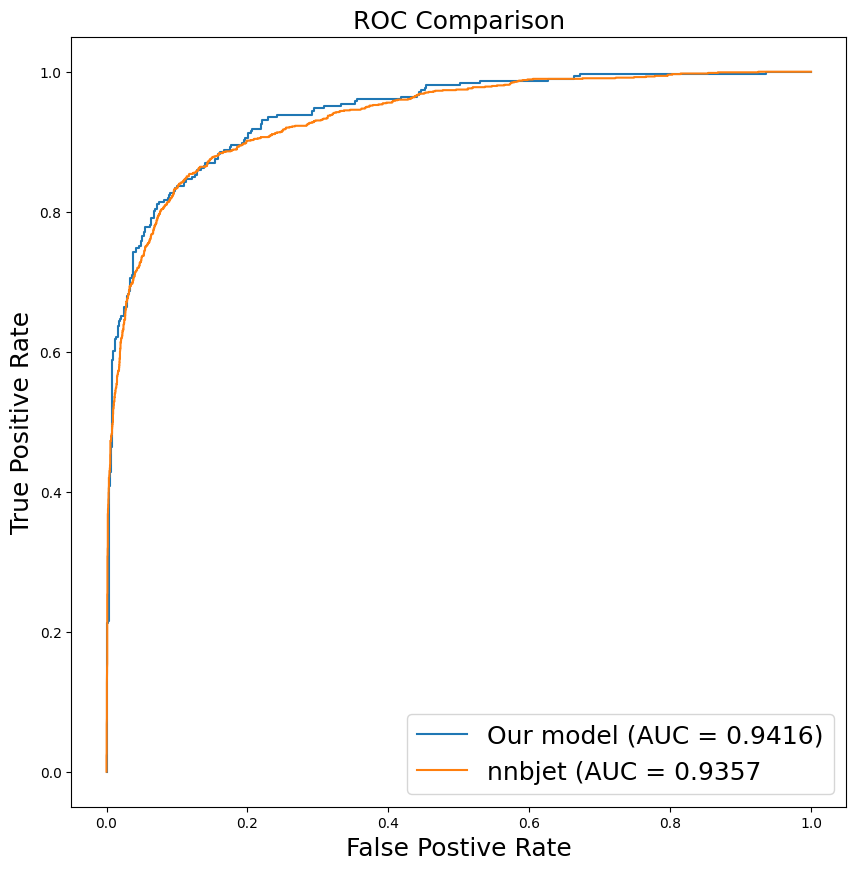

In [29]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_data, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                         # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)   # this is the auc score for nnbjet

# Plot the results:
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 18)
plt.xlabel('False Postive Rate', size = 18)
plt.ylabel('True Positive Rate', size = 18)
plt.plot(fpr,        tpr,        label = f'Our model (AUC = {auc_score:6.4f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'nnbjet (AUC = {auc_score_nnbjet:6.4f}')
plt.legend(loc='lower right', fontsize=18)
plt.show()